In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install  requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install statsmodels


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### yield curve indicator of real economic growth
from statsmodels.tsa.stattools import coint


### 
### 1. yield curve
### 2. inflation breakeven rate minus yield curve
### 3. 20-year TPI bond rate

"""
We want to detect significant economic draw down using yield curve.
"""

'\nWe want to detect significant economic draw down using yield curve.\n'

In [ ]:
import pandas as pd

In [ ]:
### Construction yield curve 
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

ticker_yield_10yr = "^TNX"
ticker_yield_5yr = "^FVX"
ticker_yield_13week = "^IRX"
_start = dt.date(1962,1,2)
_end = dt.date(2023,4,1)
yield10yr = yf.download(ticker_yield_10yr,start=_start,end=_end, interval="1d")
yield10yr = yield10yr['Close']

df = pd.DataFrame()
df["yield10yr"] = yield10yr



[*********************100%***********************]  1 of 1 completed


In [ ]:


total_count = len(df.index.values)
train_count = int( len(df.index.values)*0.7)
validate_count = int(len(df.index.values)*0.15)
test_count = len(df.index.values) - train_count-validate_count
print("total count",total_count)
print("training count ",train_count)
print("validate count",validate_count)
print("testing count",test_count)
assert  total_count== train_count+validate_count+test_count


total count 15324
training count  10726
validate count 2298
testing count 2300


In [ ]:
""" General assumptiopn:
{yield curve vs economic growth}
Assumptions is that higher difference of long maturity yield and short maturity yield, the higher expected gdp growth.

1. verify relationship between yield curve and economic growth.
2. we use {US Real GDP} as indicator of economic health of US
** Data source of gdp:https://fred.stlouisfed.org/series/GDPC1
** Data source for yields 10year and 5 year: yahoo finance
https://open.lib.umn.edu/macroeconomics/chapter/5-1-growth-of-real-gdp-and-business-cycles/#:~:text=It%20shows%20that%20economies%20go,is%20falling%20is%20a%20recession.
https://blogs.worldbank.org/opendata/introducing-wbgapi-new-python-package-accessing-world-bank-data
"""
import numpy as np
gdp = pd.read_csv("/content/drive/MyDrive/TradingData/GDPC1.csv")
gdp["DATE"]=pd.to_datetime(gdp["DATE"])
gdp = gdp.set_index("DATE")
gdp["gdpc1_pct_change"] = gdp["GDPC1"].pct_change(periods=4)

t_breakdown = pd.read_csv("/content/drive/MyDrive/TradingData/T10YIE.csv")
### preprocess
prev_i = 0
for i in range(1,len(t_breakdown.values)):
  if t_breakdown["T10YIE"].values[i]=='.':
    t_breakdown["T10YIE"].values[i]  = t_breakdown["T10YIE"].values[i-1]
t_breakdown["T10YIE"] = pd.to_numeric(t_breakdown["T10YIE"])
t_breakdown["DATE"]=pd.to_datetime(t_breakdown["DATE"])
t_breakdown = t_breakdown.set_index("DATE")

### Produce yield curve indicator:
"""
Yield curve signal is generated using  10 year yield - 13 week yield
"""
yield_curve = pd.read_csv("/content/drive/MyDrive/TradingData/T10Y2Y.csv")
yield_curve["DATE"] = pd.to_datetime(yield_curve["DATE"])
yield_curve = yield_curve.set_index("DATE")
yield_curve = yield_curve["T10Y2Y"]
for i in range(1,len(yield_curve.values)):
  if yield_curve.values[i]=='.':
    yield_curve.values[i]  = yield_curve.values[i-1]
yield_curve = pd.to_numeric(yield_curve)


inflation_rate = pd.read_csv("/content/drive/MyDrive/TradingData/PCEPILFE.csv")
inflation_rate["DATE"] = pd.to_datetime(inflation_rate["DATE"])
inflation_rate  = inflation_rate.set_index("DATE")

yield20_rate = pd.read_csv("/content/drive/MyDrive/TradingData/DFII20.csv")
yield20_rate["DATE"] = pd.to_datetime(yield20_rate["DATE"])
yield20_rate  = yield20_rate.set_index("DATE")
for i in range(1,len(yield20_rate.values)):
  if yield20_rate["DFII20"].values[i]=='.':
    yield20_rate["DFII20"].values[i]  = yield20_rate["DFII20"].values[i-1]
yield20_rate["DFII20"] = pd.to_numeric(yield20_rate["DFII20"])
print(t_breakdown["T10YIE"].head())
print(inflation_rate["PCEPILFE_PC1"].head())
print(gdp["gdpc1_pct_change"].head())
print(yield20_rate["DFII20"].head())


DATE
2003-01-02    1.64
2003-01-03    1.62
2003-01-06    1.63
2003-01-07    1.62
2003-01-08    1.71
Name: T10YIE, dtype: float64
DATE
1960-01-01    2.06735
1960-02-01    2.17951
1960-03-01    2.08146
1960-04-01    2.00453
1960-05-01    2.03778
Name: PCEPILFE_PC1, dtype: float64
DATE
1947-01-01         NaN
1947-04-01         NaN
1947-07-01         NaN
1947-10-01         NaN
1948-01-01    0.026047
Name: gdpc1_pct_change, dtype: float64
DATE
2004-07-27    2.49
2004-07-28    2.46
2004-07-29    2.44
2004-07-30    2.38
2004-08-02    2.37
Name: DFII20, dtype: float64


In [ ]:

df["GDPC1"] = np.empty(len(df.index.values))
df["gdpc1_pct_change"]  = np.empty(len(df.index.values))
df["T10YIE"] = np.empty(len(df.index.values))
df["PCEPILFE_PC1"] = np.empty(len(df.index.values))
df["DFII20"] = np.empty(len(df.index.values))
df["yieldcurve"] = np.empty(len(df.index.values))

df["GDPC1"] = np.nan
df["gdpc1_pct_change"] = np.nan
df["T10YIE"] = np.nan
df["PCEPILFE_PC1"] = np.nan
df["DFII20"] = np.nan
df["yieldcurve"]  = np.nan
## assume gdp is earlier than df index
"""
1.  the start date retrieved from  GDP csv is earlier than that of yield date 
2.  hence, when reach date

"""
print(df["DFII20"])

temp_i = 1 
### add gdp information
for curr_date in (df.index.values):
  while temp_i<len(gdp.index.values):
    tempDate = gdp.index.values[temp_i]
    if tempDate > curr_date: break
    temp_i+=1  
  index = temp_i - 1
  if(gdp.index.values[index]<=curr_date):
    gdp_ = gdp["GDPC1"][gdp.index.values[index]] 
    gdp_change = gdp["gdpc1_pct_change"][gdp.index.values[index]] 
    df["GDPC1"][curr_date] = gdp_
    df["gdpc1_pct_change"][curr_date] = gdp_change

### add 10 year  breakeven  rate
temp_i = 1
for curr_date in (df.index.values):
  while temp_i<len(t_breakdown.index.values):
    tempDate = t_breakdown.index.values[temp_i]
    if tempDate > curr_date: break
    temp_i+=1  
  index = temp_i - 1
  if(t_breakdown.index.values[index]<=curr_date):
    t_breakdown_ = t_breakdown["T10YIE"][t_breakdown.index.values[index]] 
    df["T10YIE"][curr_date] = t_breakdown_

### add inflation rate >> to verify predictability
temp_i = 1
for curr_date in (df.index.values):
  while temp_i<len(inflation_rate.index.values):
    tempDate = inflation_rate.index.values[temp_i]
    if tempDate > curr_date: break
    temp_i+=1  
  index = temp_i - 1
  if(inflation_rate.index.values[index]<=curr_date):
    inflation_rate_ = inflation_rate["PCEPILFE_PC1"][inflation_rate.index.values[index]] 
    df["PCEPILFE_PC1"][curr_date] = inflation_rate_

### add 20 year yields rate >> to verify predictability
temp_i = 1
for curr_date in (df.index.values):
  while temp_i<len(yield20_rate.index.values):
    tempDate = yield20_rate.index.values[temp_i]
    if tempDate > curr_date: break
    temp_i+=1  
  index = temp_i - 1
  if(yield20_rate.index.values[index]<=curr_date):
    yield20_rate_ = yield20_rate["DFII20"][yield20_rate.index.values[index]] 
    df["DFII20"][curr_date] = yield20_rate_



### yield curve 
temp_i = 1
for curr_date in (df.index.values):
  while temp_i<len(yield_curve.index.values):
    tempDate = yield_curve.index.values[temp_i]
    if tempDate > curr_date: break
    temp_i+=1  
  index = temp_i - 1
  if(yield_curve.index.values[index]<=curr_date):
    yield_curve_ = yield_curve[yield_curve.index.values[index]] 
    df["yieldcurve"][curr_date] = yield_curve_
print(df.head())

Date
1962-01-02   NaN
1962-01-03   NaN
1962-01-04   NaN
1962-01-05   NaN
1962-01-08   NaN
              ..
2023-03-27   NaN
2023-03-28   NaN
2023-03-29   NaN
2023-03-30   NaN
2023-03-31   NaN
Name: DFII20, Length: 15324, dtype: float64
            yield10yr     GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                      
1962-01-02       4.06  3502.298          0.075673     NaN        1.2689   
1962-01-03       4.03  3502.298          0.075673     NaN        1.2689   
1962-01-04       3.99  3502.298          0.075673     NaN        1.2689   
1962-01-05       4.02  3502.298          0.075673     NaN        1.2689   
1962-01-08       4.03  3502.298          0.075673     NaN        1.2689   

            DFII20  yieldcurve  
Date                            
1962-01-02     NaN         NaN  
1962-01-03     NaN         NaN  
1962-01-04     NaN         NaN  
1962-01-05     NaN         NaN  
1962-01-08     NaN         NaN  


In [ ]:
df = df.dropna()


            yield10yr      GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                       
2004-07-27      4.595  14457.832          0.034908    2.47       1.97648   
2004-07-28      4.585  14457.832          0.034908    2.50       1.97648   
2004-07-29      4.573  14457.832          0.034908    2.53       1.97648   
2004-07-30      4.475  14457.832          0.034908    2.49       1.97648   
2004-08-02      4.455  14457.832          0.034908    2.48       1.90017   

            DFII20  yieldcurve  
Date                            
2004-07-27    2.49        1.80  
2004-07-28    2.46        1.83  
2004-07-29    2.44        1.85  
2004-07-30    2.38        1.82  
2004-08-02    2.37        1.82  


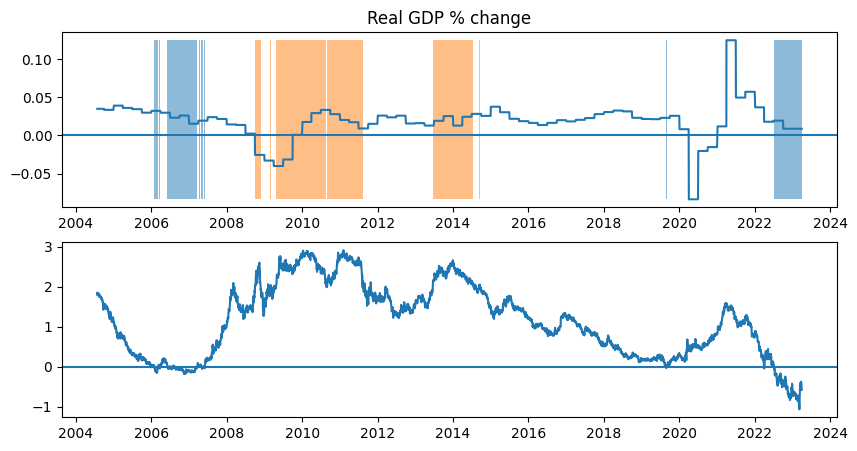

In [ ]:
fig, ax = plt.subplots(2,figsize=(10,5))
# ax[0].plot(df_train.index.values,df_train["GDPC1"].values)
ax[0].plot(df.index.values,df["gdpc1_pct_change"])
ax[0].axhline(y=0)
ax[0].title.set_text("Real GDP % change")
yield_curve_values = df["yieldcurve"].values
ax[0].fill_between(df.index.values, min(df["gdpc1_pct_change"]), max(df["gdpc1_pct_change"]), where=(yield_curve_values <= 0), alpha=0.5)
ax[0].fill_between(df.index.values, min(df["gdpc1_pct_change"]), max(df["gdpc1_pct_change"]), where=(yield_curve_values > 2), alpha=0.5)
ax[1].plot(df.index.values,df["yieldcurve"].values)
ax[1].axhline(y=0)
print(df.head())
plt.show()

In [ ]:
"""
Based on historic data of yield curve and pct chanage
As shown in the above graph,
orange region represent the section which yield curve has positive slope
blue region represent the section which yield curve has negative slope
it can be shown that when inverted yield has strong indication of upcoming economic down turn.
as a result, the  (- or 0) slope of yield curve indicate upcoming recession.
                  (+) high yield curve indicate period of healthy economic condition.

More explaination...  theories >>>>>>>
"""





'\nBased on historic data of yield curve and pct chanage\nAs shown in the above graph,\norange region represent the section which yield curve has positive slope\nblue region represent the section which yield curve has negative slope\nit can be shown that when inverted yield has strong indication of upcoming economic down turn.\nas a result, the  (- or 0) slope of yield curve indicate upcoming recession.\n                  (+) high yield curve indicate period of healthy economic condition.\n\nMore explaination...  theories >>>>>>>\n'

In [ ]:
"""
remomve null rows of spy since spy start from later years
"""
spy500 = yf.download("^GSPC",start=_start,end=_end, interval="1d")
spy500 = spy500["Close"]
spy500_etf = yf.download("SPY",start=_start,end=_end, interval="1d")
spy500_etf = spy500_etf["Close"]
# fig, ax = plt.subplots(2,figsize=(20,5))
# ax[0].plot(spy500_etf.index.values,spy500[spy500_etf.index.values])
# ax[1].plot(spy500_etf.index.values,spy500_etf.values)
# plt.show()
# print(spy500[spy500_etf.index.values].head())
# print((spy500_etf*10).head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:

df["SPY"] = spy500_etf
df_SPYETF = df.dropna()
print(df_SPYETF.head())
spy_length = len(df_SPYETF.values)
spy_train = int(spy_length*0.7)
spy_validate = int(spy_train*0.15)
spy_test = spy_length - spy_train - spy_validate

            yield10yr      GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                       
2004-07-27      4.595  14457.832          0.034908    2.47       1.97648   
2004-07-28      4.585  14457.832          0.034908    2.50       1.97648   
2004-07-29      4.573  14457.832          0.034908    2.53       1.97648   
2004-07-30      4.475  14457.832          0.034908    2.49       1.97648   
2004-08-02      4.455  14457.832          0.034908    2.48       1.90017   

            DFII20  yieldcurve         SPY  
Date                                        
2004-07-27    2.49        1.80  109.769997  
2004-07-28    2.46        1.83  110.099998  
2004-07-29    2.44        1.85  110.570000  
2004-07-30    2.38        1.82  110.839996  
2004-08-02    2.37        1.82  111.070000  


In [ ]:
"""
We based on previous data exploration we know the relationship between yield curve and economic health.
since spy500 is an indication  us economy health
"""


'\nWe based on previous data exploration we know the relationship between yield curve and economic health.\nsince spy500 is an indication  us economy health\n'

            yield10yr      GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                       
2004-07-27      4.595  14457.832          0.034908    2.47       1.97648   
2004-07-28      4.585  14457.832          0.034908    2.50       1.97648   
2004-07-29      4.573  14457.832          0.034908    2.53       1.97648   
2004-07-30      4.475  14457.832          0.034908    2.49       1.97648   
2004-08-02      4.455  14457.832          0.034908    2.48       1.90017   

            DFII20  yieldcurve         SPY  
Date                                        
2004-07-27    2.49        1.80  109.769997  
2004-07-28    2.46        1.83  110.099998  
2004-07-29    2.44        1.85  110.570000  
2004-07-30    2.38        1.82  110.839996  
2004-08-02    2.37        1.82  111.070000  


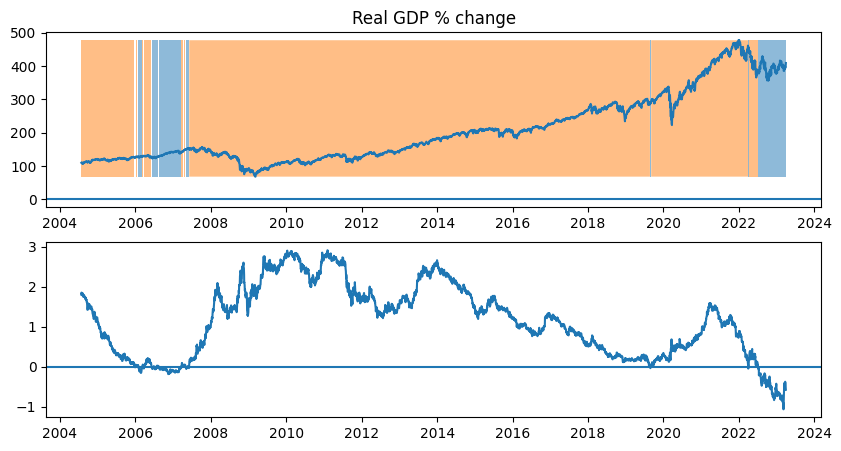

In [ ]:
fig, ax = plt.subplots(2,figsize=(10,5))
ax[0].plot(df_SPYETF.index.values,df_SPYETF["SPY"])
ax[0].axhline(y=0)
ax[0].title.set_text("Real GDP % change")
yield_curve_values = df_SPYETF["yieldcurve"].values
ax[0].fill_between(df_SPYETF.index.values, min(df_SPYETF["SPY"]), max(df_SPYETF["SPY"]), where=(yield_curve_values <= 0), alpha=0.5)
ax[0].fill_between(df_SPYETF.index.values, min(df_SPYETF["SPY"]), max(df_SPYETF["SPY"]), where=(yield_curve_values > 0), alpha=0.5)
ax[1].plot(df_SPYETF.index.values,df_SPYETF["yieldcurve"].values)
ax[1].axhline(y=0)
print(df_SPYETF.head())
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


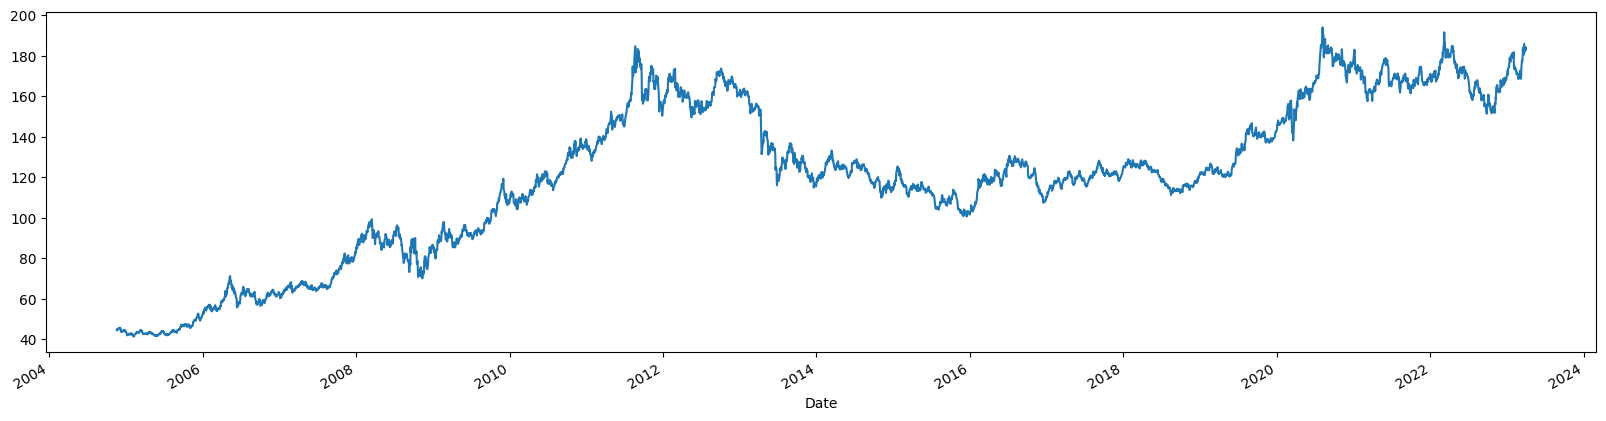

            yield10yr      GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                       
2004-07-27      4.595  14457.832          0.034908    2.47       1.97648   
2004-07-28      4.585  14457.832          0.034908    2.50       1.97648   
2004-07-29      4.573  14457.832          0.034908    2.53       1.97648   
2004-07-30      4.475  14457.832          0.034908    2.49       1.97648   
2004-08-02      4.455  14457.832          0.034908    2.48       1.90017   

            DFII20  yieldcurve         SPY  GLD  year20ETF  
Date                                                        
2004-07-27    2.49        1.80  109.769997  NaN  83.410004  
2004-07-28    2.46        1.83  110.099998  NaN  83.419998  
2004-07-29    2.44        1.85  110.570000  NaN  83.610001  
2004-07-30    2.38        1.82  110.839996  NaN  84.589996  
2004-08-02    2.37        1.82  111.070000  NaN  84.370003  


In [ ]:
"""
Inverted yield curve is a signal for SPY downturn.
Here we take gold as an asset for "defense" during economic down turn 
"""
gold_price = yf.download("GLD",start=_start,end=_end,interval="1d")
gold_price = gold_price["Close"]
year20Bond = yf.download("TLT",start=_start,end=_end,interval="1d")
df["GLD"] = gold_price
df["year20ETF"]  = year20Bond["Close"]
fig, axes = plt.subplots(1,figsize=(20,5))
df["GLD"].plot(axes=axes)
plt.show()
print(df.head())

In [ ]:
"""
1. yield curve highest** >> buy stocks
2. inflation curve - yield curve is highest, strong indications to buy gold.
3. If the 20-year TIP rate is highest, you buy long-term bonds.

"""
df["Inflation_yield"] = df["T10YIE"]-df["yieldcurve"]
df.head()



,yield10yr,GDPC1,gdpc1_pct_change,T10YIE,PCEPILFE_PC1,DFII20,yieldcurve,SPY,GLD,year20ETF,Inflation_yield
Date,,,,,,,,,,,
2004-07-27,4.595,14457.832,0.034908,2.47,1.97648,2.49,1.80,109.769997,NaN,83.410004,0.67
2004-07-28,4.585,14457.832,0.034908,2.50,1.97648,2.46,1.83,110.099998,NaN,83.419998,0.67
2004-07-29,4.573,14457.832,0.034908,2.53,1.97648,2.44,1.85,110.570000,NaN,83.610001,0.68
2004-07-30,4.475,14457.832,0.034908,2.49,1.97648,2.38,1.82,110.839996,NaN,84.589996,0.67
2004-08-02,4.455,14457.832,0.034908,2.48,1.90017,2.37,1.82,111.070000,NaN,84.370003,0.66


In [ ]:
""" Generate trading signals """ 
trading_signal = []

for i in range(len(df.values)):
  if (df["yieldcurve"].values[i]> (df["DFII20"].values[i]) and (df["yieldcurve"].values[i]>df["Inflation_yield"].values[i])):
    trading_signal+=[1]
  elif(df["Inflation_yield"].values[i]>df["yieldcurve"].values[i] and df["Inflation_yield"].values[i]>df["DFII20"].values[i]):
    trading_signal+=[0]
  else:
    trading_signal+=[-1]


df["Trade Signal"]=trading_signal


In [ ]:
df = df.dropna()

print(df)

            yield10yr      GDPC1  gdpc1_pct_change  T10YIE  PCEPILFE_PC1  \
Date                                                                       
2004-11-18      4.117  14605.595          0.033558    2.48       2.06234   
2004-11-19      4.196  14605.595          0.033558    2.53       2.06234   
2004-11-22      4.165  14605.595          0.033558    2.56       2.06234   
2004-11-23      4.184  14605.595          0.033558    2.54       2.06234   
2004-11-24      4.195  14605.595          0.033558    2.56       2.06234   
...               ...        ...               ...     ...           ...   
2023-03-27      3.528  20182.491          0.008813    2.24       4.59717   
2023-03-28      3.564  20182.491          0.008813    2.31       4.59717   
2023-03-29      3.566  20182.491          0.008813    2.33       4.59717   
2023-03-30      3.551  20182.491          0.008813    2.34       4.59717   
2023-03-31      3.494  20182.491          0.008813    2.32       4.59717   

           

In [ ]:
### split
total_count = len(df.index.values)
train_count = int( len(df.index.values)*0.7)
validate_count = int(len(df.index.values)*0.15)
test_count = len(df.index.values) - train_count-validate_count
df_train = df[:train_count]
df_validate = df[train_count:train_count+validate_count]
df_test = df[train_count+validate_count:]

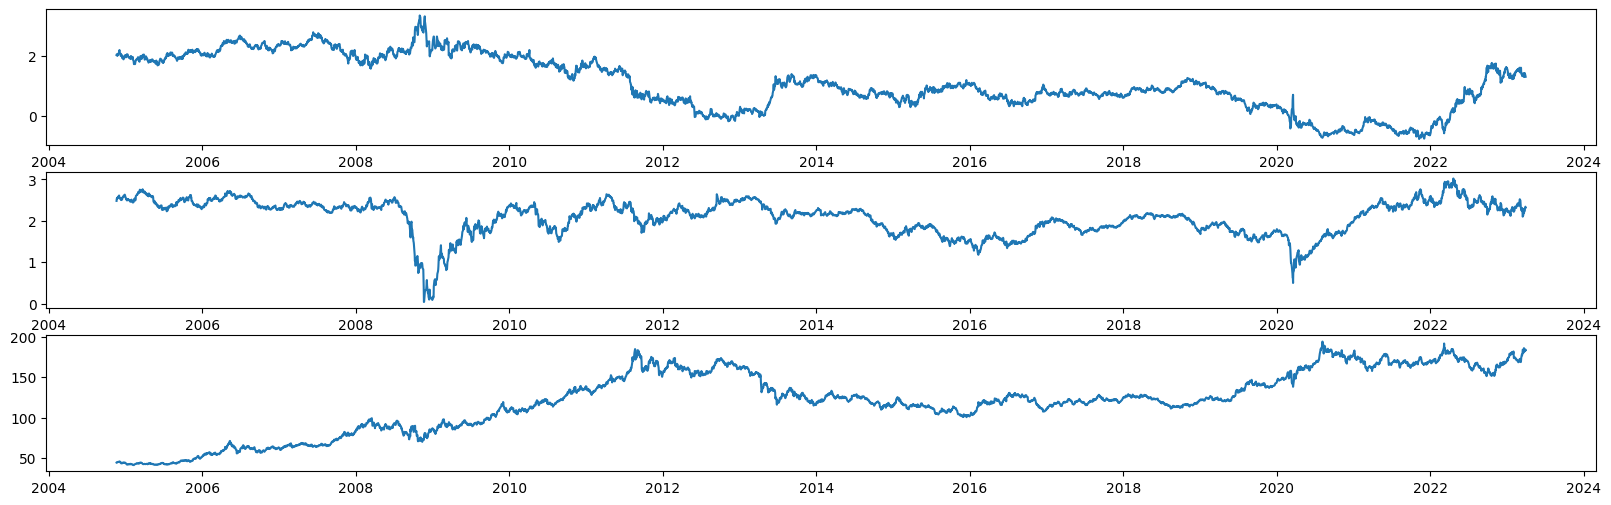

In [ ]:
"""
10-year breakeven inflation rate act as inflation rate expectation
"""
fig, axes = plt.subplots(3,figsize=(20,6))
axes[0].plot(df.index,df["DFII20"].values)
axes[1].plot(df.index,df["T10YIE"].values)
axes[2].plot(df.index,df["GLD"].values)
plt.show()


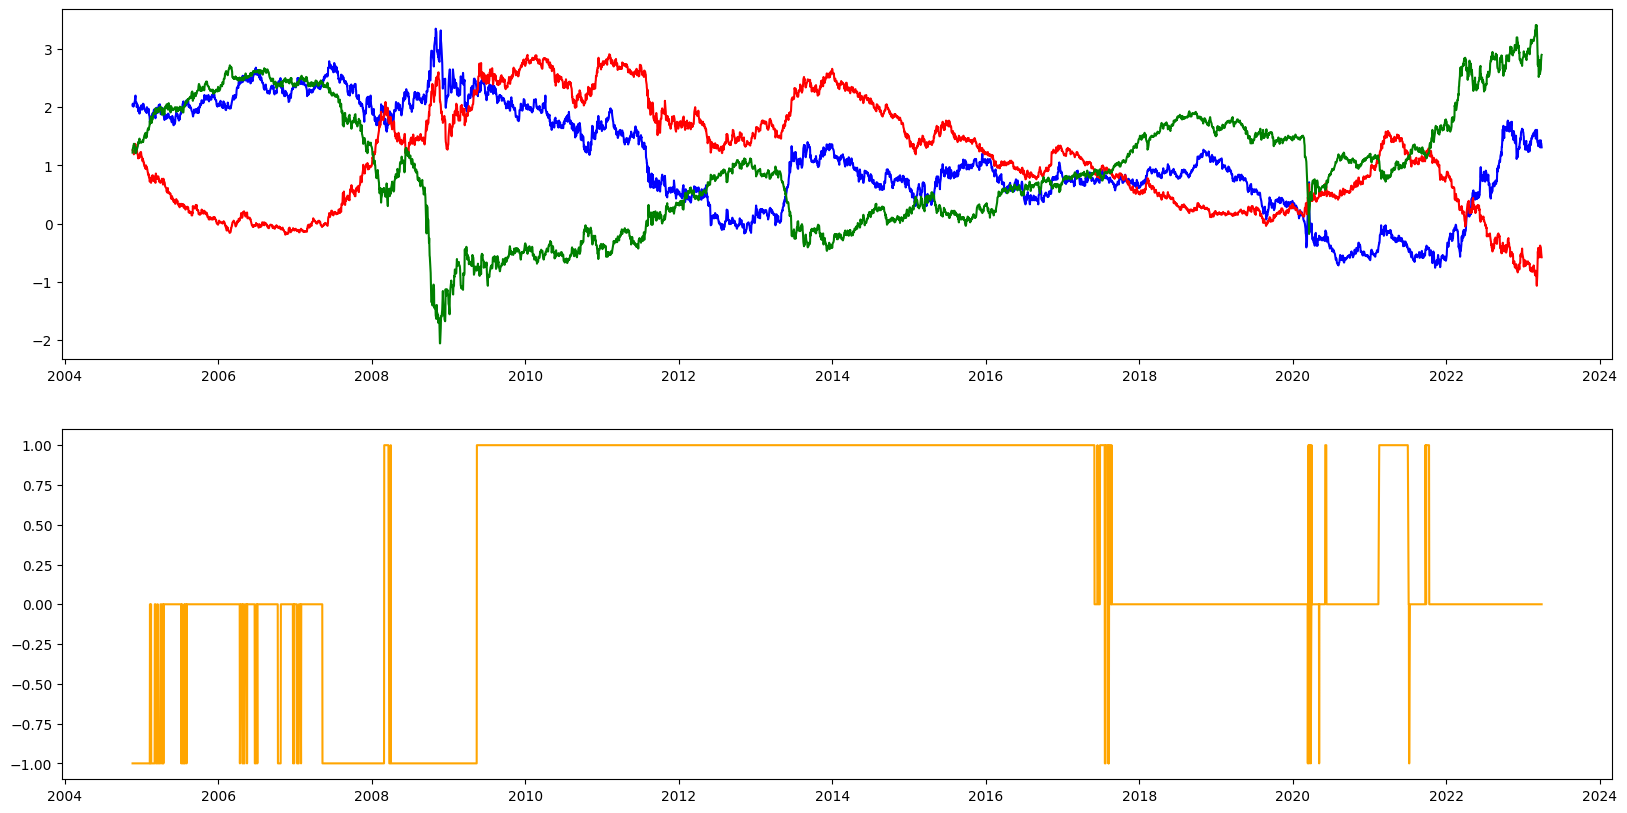

In [ ]:
fig,ax = plt.subplots(2,figsize=(20,10))
ax[0].plot(df.index, df["DFII20"].values,color="blue")
ax[0].plot(df.index, df["yieldcurve"].values,color="red")
ax[0].plot(df.index, df["Inflation_yield"].values,color="green")
ax[1].plot(df.index, df["Trade Signal"].values,color="orange")
plt.show()



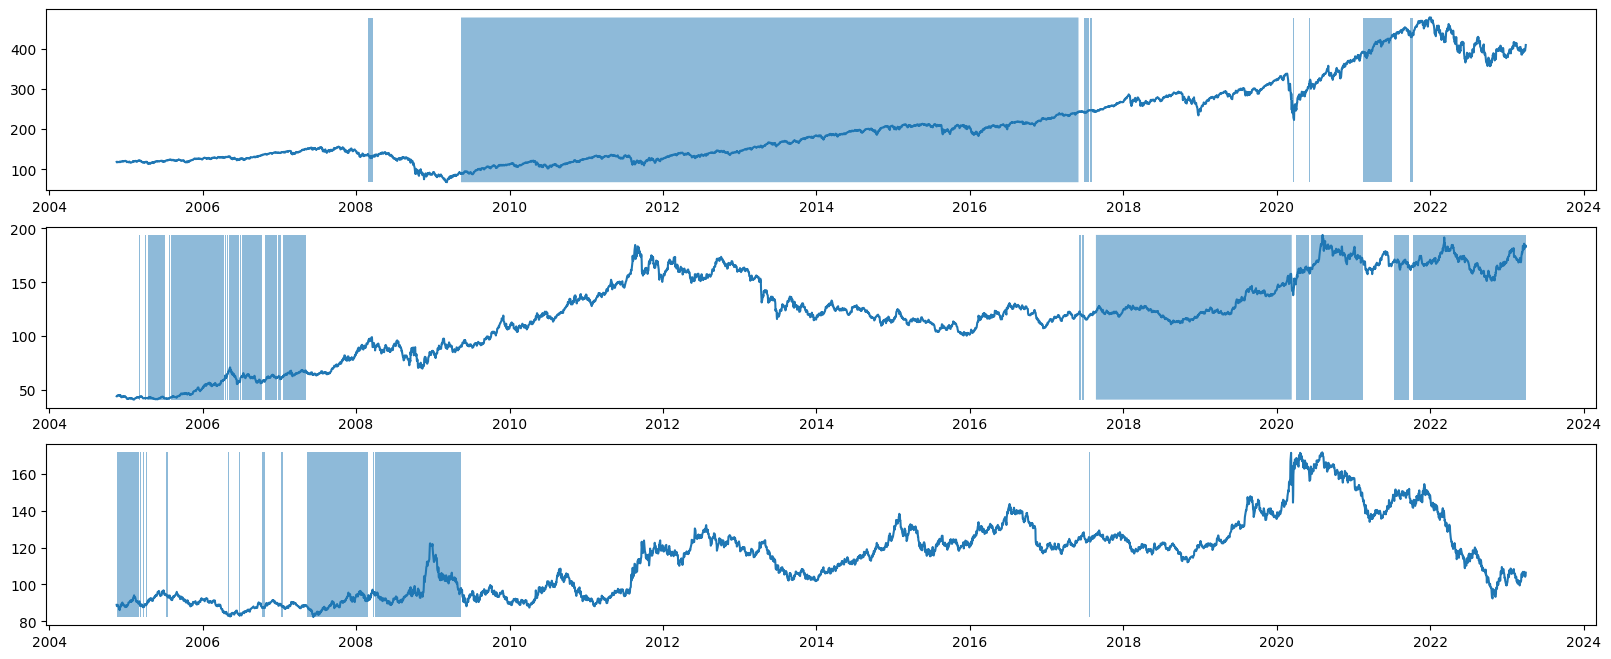

In [ ]:

fig,axs = plt.subplots(3,figsize=(20,8))
axs[0].plot(df.index,df["SPY"].values)
axs[0].fill_between(df.index.values, min(df["SPY"]), max(df["SPY"]), where=(df["Trade Signal"].values ==1), alpha=0.5)
axs[1].plot(df.index,df["GLD"].values)
axs[1].fill_between(df.index.values, min(df["GLD"]), max(df["GLD"]), where=(df["Trade Signal"].values ==0), alpha=0.5)
axs[2].plot(df.index,df["year20ETF"].values)
axs[2].fill_between(df.index.values, min(df["year20ETF"]), max(df["year20ETF"]), where=(df["Trade Signal"].values ==-1), alpha=0.5)

plt.show()

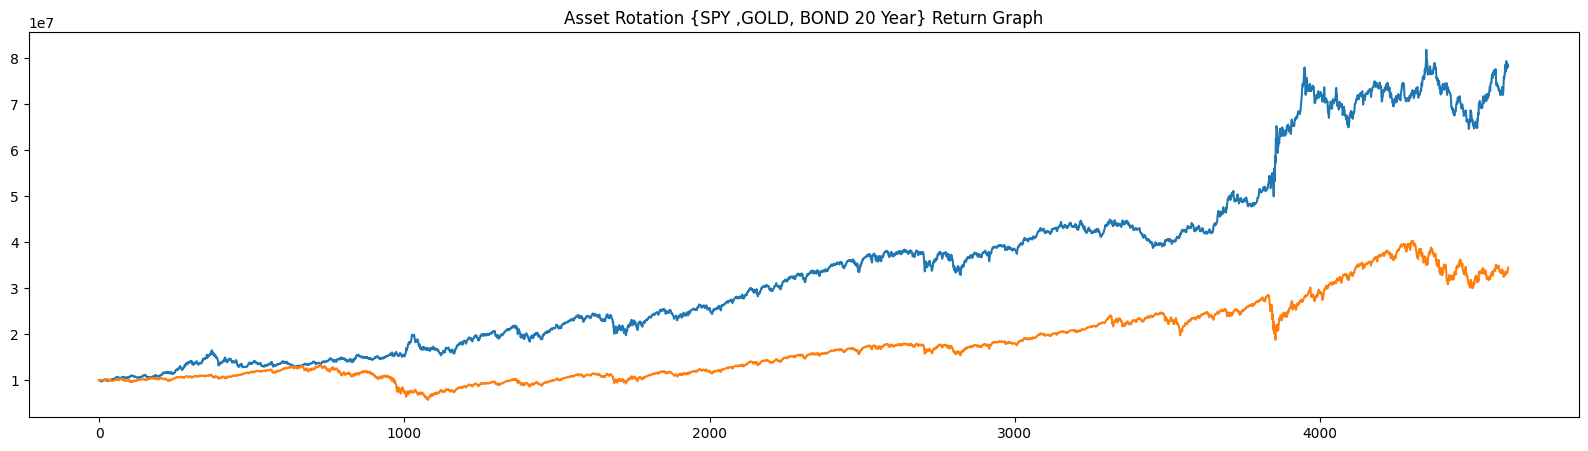

Cumulative Return Rotation Asset:  682.6694104427022
Sharpe Ratio: 0.7850564187313336


In [ ]:
def backtest_trade_full_asset(df,investment):
  gold = df["GLD"].values
  bondETF = df["year20ETF"].values
  SPY = df["SPY"].values
  cash = investment
  signal = df["Trade Signal"].values
  investments = [gold,SPY,bondETF]
  investments_quantity = [0,0,0]
  last_investment = 0
  returnCurve =  np.array([])
  for i in range(len(df.index.values)):
    if signal[i] ==1:
       cash += investments[last_investment][i]*investments_quantity[last_investment] 
       quantity = int(cash/SPY[i])
       cash =0
       last_investment = 1
       investments_quantity[1] = quantity
    elif signal[i]==0:
       cash += investments[last_investment][i]*investments_quantity[last_investment]
       quantity = int(cash/gold[i])
       cash =0
       last_investment = 0
       investments_quantity[0] = quantity
    else:
       cash += investments[last_investment][i]*investments_quantity[last_investment]
       quantity = int(cash/bondETF[i])
       cash =0
       last_investment = 2
       investments_quantity[2] = quantity
    returnCurve = np.append(returnCurve, [cash+investments[last_investment][i]*investments_quantity[last_investment]])
  return returnCurve
def backtest_buyHold(df,investment):
  spyquantity = investment/df["SPY"].values[0]
  returnCurve = np.array([])
  for i in range(len(df.index.values)):
    returnCurve = np.append(returnCurve, [spyquantity*df["SPY"].values[i]])
  return returnCurve



returnCurve = backtest_trade_full_asset(df,10000000)
returnCurve2 = backtest_buyHold(df,10000000)

cumulative_return = (returnCurve[-1]/returnCurve[0]-1)*100
report = pd.DataFrame({"Return":returnCurve,"Date":df.index}) 
report = report.set_index("Date")
report["Daily Return"] = report["Return"].pct_change(1)
sharpe_ratio_1 = report["Daily Return"].mean()/report["Daily Return"].std()
fig, axes = plt.subplots(1,figsize=(20,5))
axes.plot(returnCurve)
axes.title.set_text("Asset Rotation {SPY ,GOLD, BOND 20 Year} Return Graph")
axes.plot(returnCurve2)
plt.show()
print("Cumulative Return Rotation Asset: ", cumulative_return)
print("Sharpe Ratio:", 252**(1/2)*sharpe_ratio_1)


In [ ]:
returnCurve[-1]

78266637.58145142